# RPM Tumor Time Series Preprocessing


In [1]:
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb

In [2]:
# !pip install phate

## Read in Files

In [3]:
indir = "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/data/single-cell-rna-seq/RPM-time-series/loom/"

samples = ['SRR11594440','SRR11594441','SRR11594442','SRR11594443','SRR11594444','SRR11594445','SRR11594446']
[a1,a2,a3,a4,a5,a6,a7] = [mb.pp.read_loom(sample, indir) for sample in samples]
a1 = a1.concatenate(a2) #concatenate both day_4 datasets into one


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Doublet detection

Given a raw (unnormalized) UMI counts matrix counts_matrix with cells as rows and genes as columns, calculate a doublet score for each cell:

```import scrublet as scr
scrub = scr.Scrublet(counts_matrix)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scr.scrub_doublets() simulates doublets from the observed data and uses a k-nearest-neighbor classifier to calculate a continuous doublet_score (between 0 and 1) for each transcriptome. The score is automatically thresholded to generate predicted_doublets, a boolean array that is True for predicted doublets and False otherwise.
```
Best practices:
- When working with data from multiple samples, run Scrublet on each sample separately. Because Scrublet is designed to detect technical doublets formed by the random co-encapsulation of two cells, it may perform poorly on merged datasets where the cell type proportions are not representative of any single sample.
- Check that the doublet score threshold is reasonable (in an ideal case, separating the two peaks of a bimodal simulated doublet score histogram, as in this example), and adjust manually if necessary.
- Visualize the doublet predictions in a 2-D embedding (e.g., UMAP or t-SNE). Predicted doublets should mostly co-localize (possibly in multiple clusters). If they do not, you may need to adjust the doublet score threshold, or change the pre-processing parameters to better resolve the cell states present in your data.


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 6.7%
Estimated detectable doublet fraction = 75.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
Elapsed time: 12.9 seconds
Running UMAP...
Done.


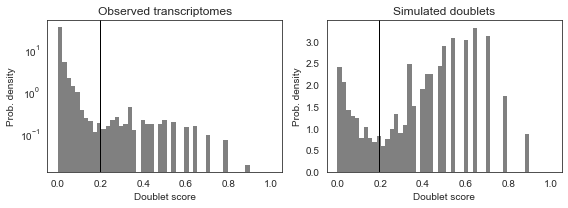

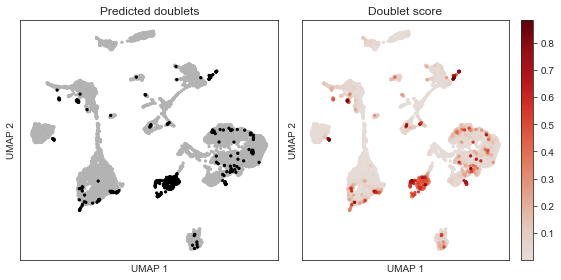

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 15.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 6.3 seconds
Running UMAP...
Done.


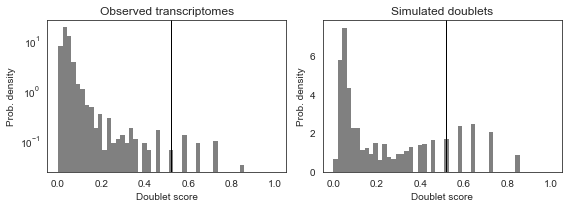

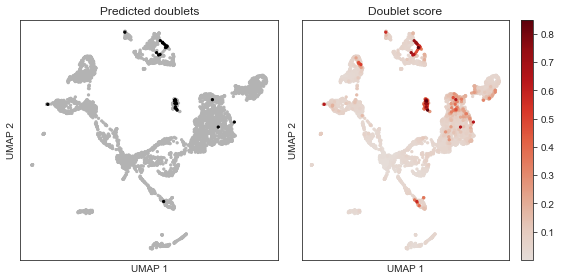

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 8.5%
Estimated detectable doublet fraction = 71.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.9%
Elapsed time: 7.3 seconds
Running UMAP...
Done.


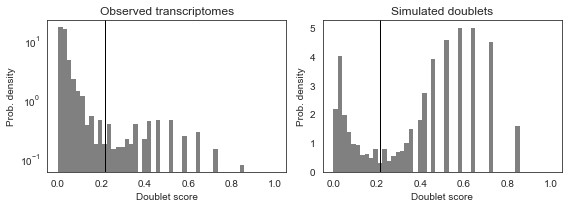

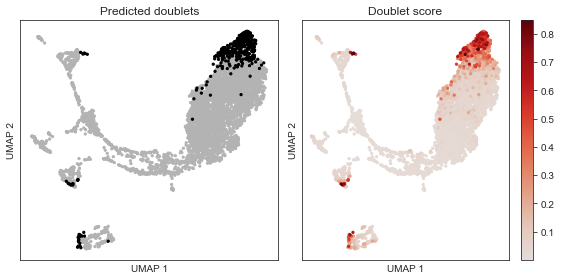

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 14.9%
Estimated detectable doublet fraction = 66.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 22.3%
Elapsed time: 8.4 seconds
Running UMAP...
Done.


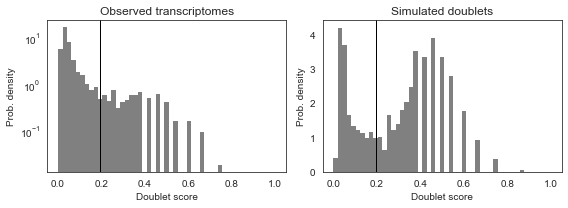

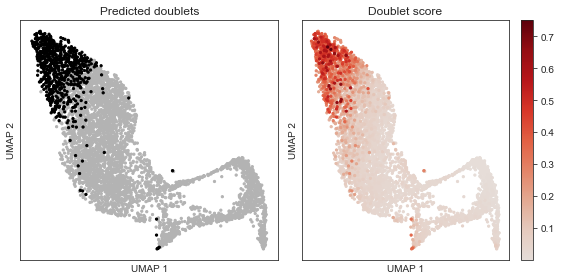

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 17.4%
Estimated detectable doublet fraction = 77.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 22.5%
Elapsed time: 8.6 seconds
Running UMAP...
Done.


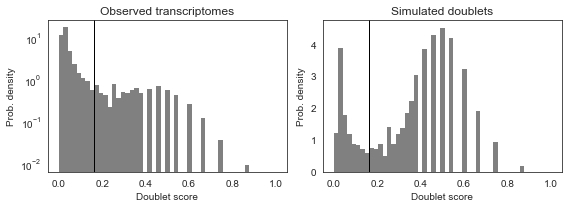

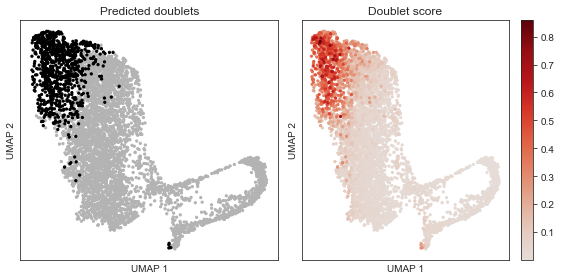

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 13.2%
Estimated detectable doublet fraction = 73.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 17.9%
Elapsed time: 7.4 seconds
Running UMAP...
Done.


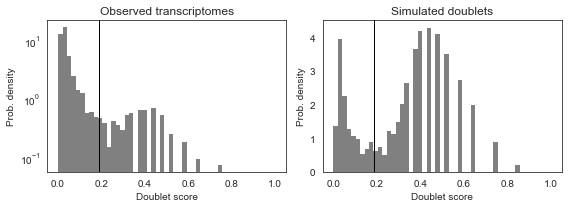

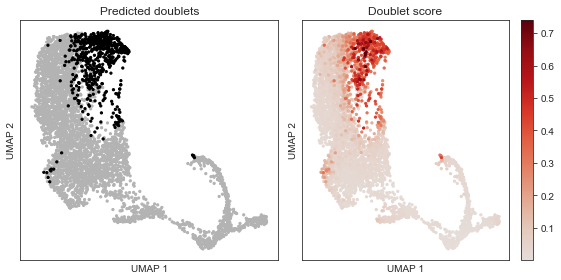

In [4]:
for a in [a1,a3,a4,a5,a6,a7]:
    mb.pp.doublet_detections(a, layer = 'matrix', plot = True, log_transform = True)

In [5]:
for  a in [a1,a3,a4,a5,a6,a7]:
    print((a.obs.predicted_doublets == True).sum())

549
32
371
760
886
595


## Filter and concatenate

In [6]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM', 'TMED11','RSL24D1','OLFR123','ADAM20']


In [4]:
batch_categories = ['4','7','11','14','17','21']
batch_key = 'timepoint'
adatas = [a1,a3,a4,a5,a6,a7] #a2 is already merged with a1

a1 = adatas.pop(0)
adata = a1.concatenate(adatas, batch_key=batch_key, batch_categories=batch_categories)

In [5]:
adata

AnnData object with n_obs × n_vars = 31514 × 32285
    obs: 'Clusters', '_X', '_Y', 'batch', 'timepoint'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
adata_raw = adata.copy()

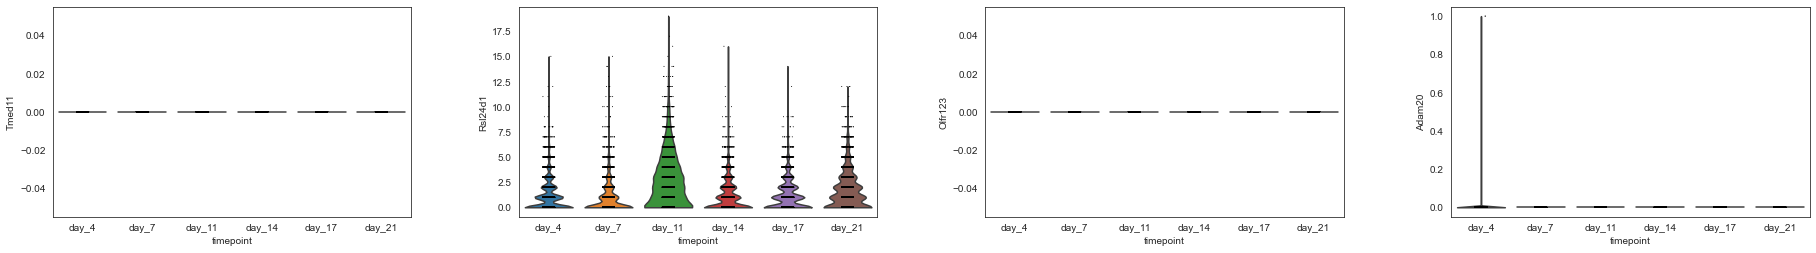

In [38]:
sc.pl.violin(adata, keys=['Tmed11','Rsl24d1','Olfr123','Adam20'], groupby='timepoint', ymin = 0, ymax = 1, save='genes_RPM.pdf')

## Filter and Normalize with Scanpy
This does a log transformation on the normalized data

In [9]:
mb.pp.scanpy_recipe(adata,retain_genes=[i.capitalize() for i in tfs], min_genes = 100, min_cells = 3)

Filtered out 10997 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


AnnData object with n_obs × n_vars = 30365 × 21288
    obs: 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

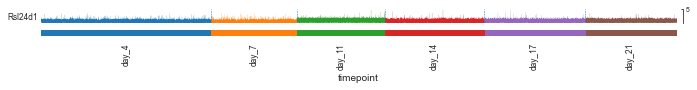

In [8]:
sc.pl.tracksplot(adata, var_names=['Rsl24d1'], groupby='timepoint')

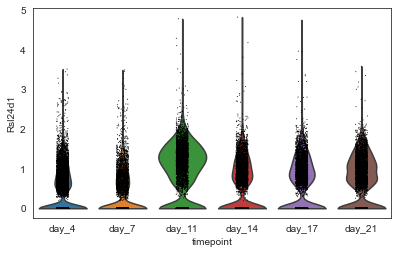

In [27]:
sc.pl.violin(adata, keys=['Rsl24d1'], groupby='timepoint', save='Rsl24d1_RPM.pdf')

Compare our filtered dataset to the Ireland et al. paper. They have a spreadsheet of the barcodes they kept for downstream analyses.

In [7]:
bcs = pd.read_csv('../../../data/single-cell-rna-seq/RPM-time-series/RPM_cell_barcodes.csv', index_col=0, header = 0)
bcs['barcode_short'] = [i.split('_')[0] for i in bcs['Tumor Cell Barcodes']]

adata.obs['barcode'] = [str(i.split(":")[1].split('x')[0]) for i in adata.obs_names]

In [8]:
print("Number of cells kept in Ireland et al. from time series")
len(bcs.loc[[i not in ['RPM1','RPM2','RPM3','RPM4'] for i in bcs['Day or Tumor Number']]])

Number of cells kept in Ireland et al. from time series


15434

In [9]:
tmp = adata.obs.copy()
tmp['ID'] = tmp.index

In [10]:
tmp = pd.merge(tmp, bcs, left_on = ['barcode','timepoint'], right_on = ['barcode_short','Day or Tumor Number'], validate='many_to_one')

In [11]:
tmp.ID

0        SRR11594440:AACCACATCCACCTCAx-0-4
1        SRR11594440:AAAGGTAGTTGCAAGGx-0-4
2        SRR11594440:AAGCGAGAGACCAGACx-0-4
3        SRR11594440:AAGTCGTTCGTAGGGAx-0-4
4        SRR11594440:AAGTACCGTTCGTACAx-0-4
                       ...                
15429     SRR11594446:TTTGACTGTACCTTCCx-21
15430     SRR11594446:TTTGGAGGTGGCTACCx-21
15431     SRR11594446:TTTGATCAGACTTCGTx-21
15432     SRR11594446:TTTGGTTAGGAAGTGAx-21
15433     SRR11594446:TTTGGAGCACCAACATx-21
Name: ID, Length: 15434, dtype: object

In [12]:
adata_raw = adata_raw[list(tmp.ID)]

In [13]:
adata_raw

View of AnnData object with n_obs × n_vars = 15434 × 32285
    obs: 'Clusters', '_X', '_Y', 'batch', 'timepoint'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [14]:
adata_raw.write_csvs('../../out/RPM-time-series/RPM_raw', skip_data=False)

writing .csv files to ../../out/RPM-time-series/RPM_raw


In [16]:
adata = adata[list(tmp.ID)]

In [17]:
tmp.index = tmp.ID

In [18]:
adata.obs['ireland_barcode'] = tmp['Tumor Cell Barcodes']

Trying to set attribute `.obs` of view, copying.


In [19]:
adata

AnnData object with n_obs × n_vars = 15434 × 21288
    obs: 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

We also want to make sure this aligns with the pseudotime coordinates Abbie sent us.

In [20]:
pseudo = pd.read_csv('../../../data/single-cell-rna-seq/RPM-time-series/PseudoCorr.csv', header = 0)


In [21]:
tmp = pd.merge(pseudo, tmp, left_on = ['Barcode'], right_on=['Tumor Cell Barcodes'], validate='one_to_one')

In [22]:
tmp.index = tmp.ID

In [23]:
adata = adata[list(tmp.ID)]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 15138 × 21288
    obs: 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [25]:
adata.write_h5ad('../../out/RPM-time-series/adata_01.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'barcode' as categorical


## PCA and UMAP

In [2]:
adata = sc.read_h5ad('../../out/RPM-time-series/adata_01.h5ad')

In [27]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=False)
scv.pp.neighbors(adata, random_state=0)
scv.tl.umap(adata, random_state=0)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


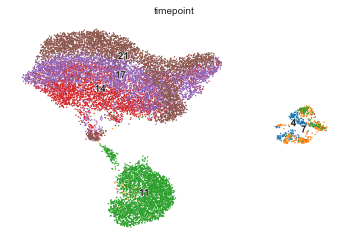

In [3]:
scv.pl.umap(adata, color = 'timepoint')

saving figure to file ./figures/scvelo_doublets.png


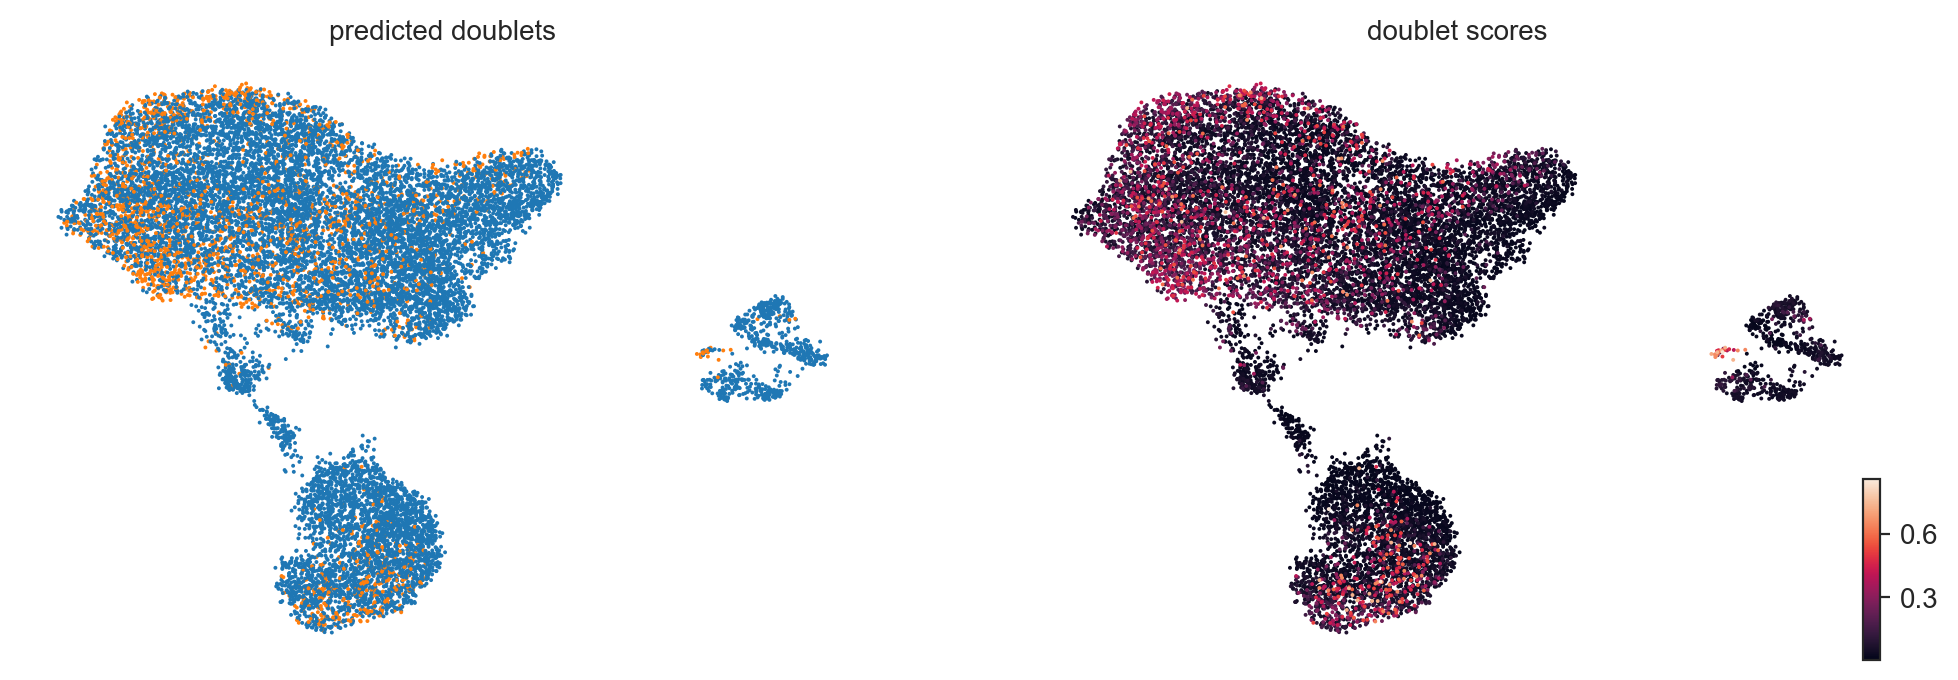

In [4]:
scv.pl.umap(adata, color = ['predicted_doublets','doublet_scores'], save = 'doublets.png', dpi = 200)

In [32]:
print((adata.obs.predicted_doublets == 'True').sum())
print(adata.shape[0])

2175
15138


We are not going to remove these doublets since they were not removed in Ireland et al. so we stay consistent with those analyses. However, we will keep the prediction as an attribute so we ensure that archetypes are not enriched for doublets later.

In [36]:
adata.write_h5ad('../../out/RPM-time-series/adata_01.h5ad')

## EMT Signature

In [30]:
adata= sc.read_h5ad('../../out/RPM-time-series/adata_01.h5ad')

In [37]:
emt = pd.read_csv('../../../data/single-cell-rna-seq/Lung EMT signature.csv', header = 0, index_col = 0)


In [38]:
sc.tl.score_genes(adata, gene_list=[i.capitalize() for i in emt.loc[emt['Group']=='M'].index], score_name='M')
sc.tl.score_genes(adata, gene_list=[i.capitalize() for i in emt.loc[emt['Group']=='E'].index], score_name='E')

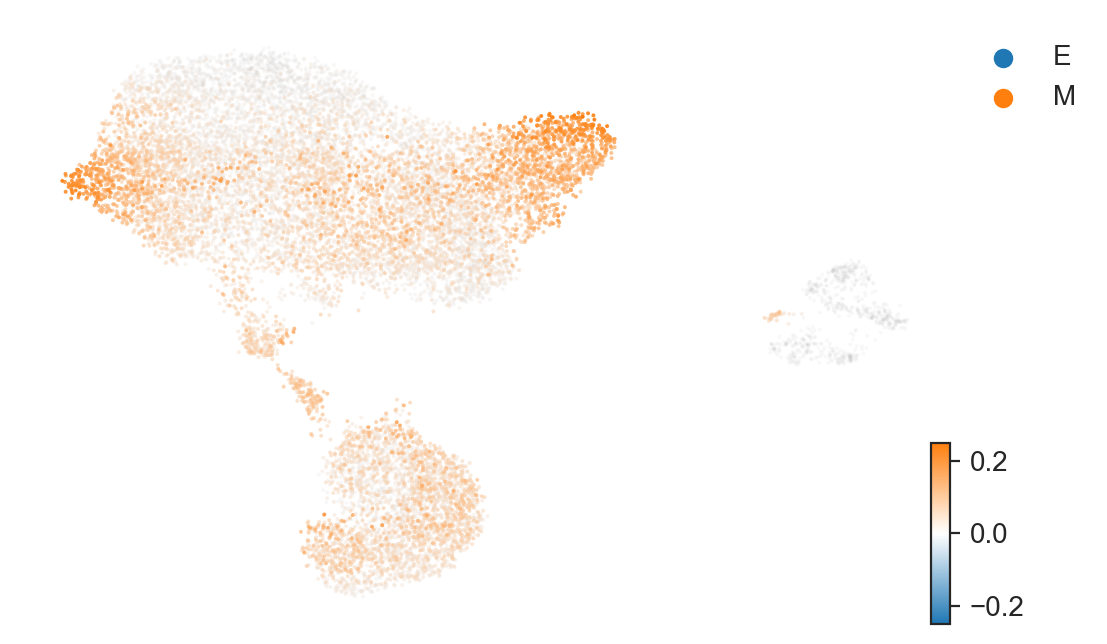

In [39]:
scv.pl.umap(adata, color_gradients=['E','M'], smooth = True, perc = [5,95], dpi = 200, colorbar = True)


## Cell cycle regression 

In [44]:

s_genes_list = \
    ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']

g2m_genes_list = \
    ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

ctrl_size = min(len(s_genes_list), len(g2m_genes_list))

sc.tl.score_genes(adata, gene_list=s_genes_list, score_name="S_score", ctrl_size = ctrl_size)
sc.tl.score_genes(adata, gene_list=g2m_genes_list, score_name="G2M_score", ctrl_size = ctrl_size)
scores = adata.obs[["S_score", "G2M_score"]]

phase = pd.Series("S", index=scores.index)  # default phase is S
phase[scores.G2M_score > scores.S_score] = "G2M"  # G2M, if G2M is higher than S
phase[np.all(scores < 0, axis=1)] = "G1"  # G1, if all scores are negative

adata.obs["phase"] = phase


saving figure to file ./figures/scvelo_cc.png


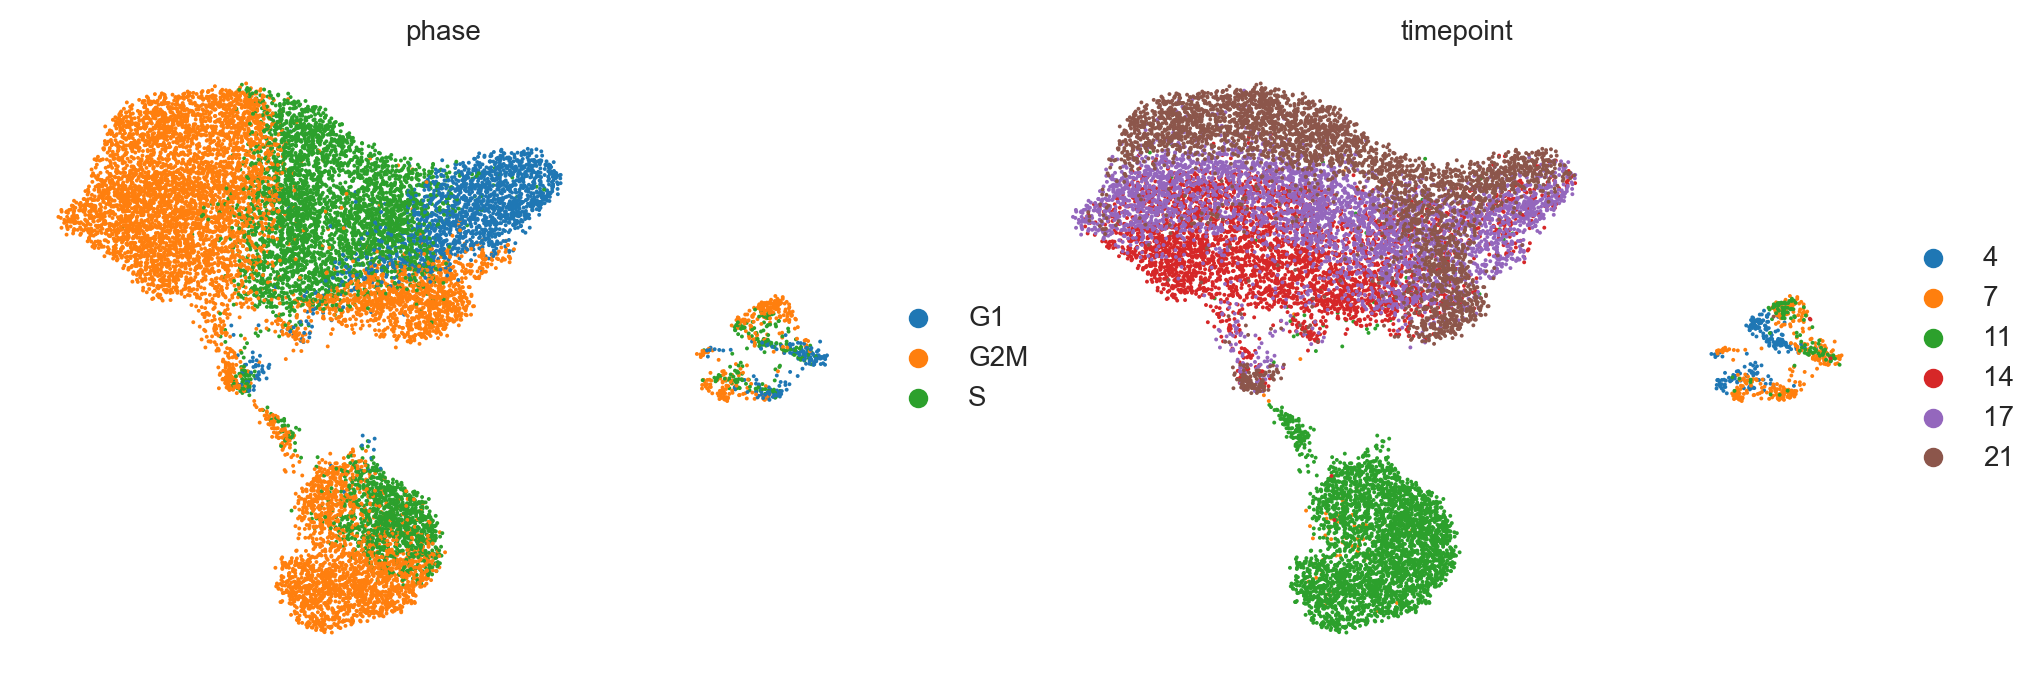

In [8]:
scv.pl.umap(adata, color=['phase','timepoint'],legend_loc = 'on right', save = 'cc.png', dpi = 200)

In [48]:
adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]


saving figure to file ./figures/scvelo_cc_diff.png


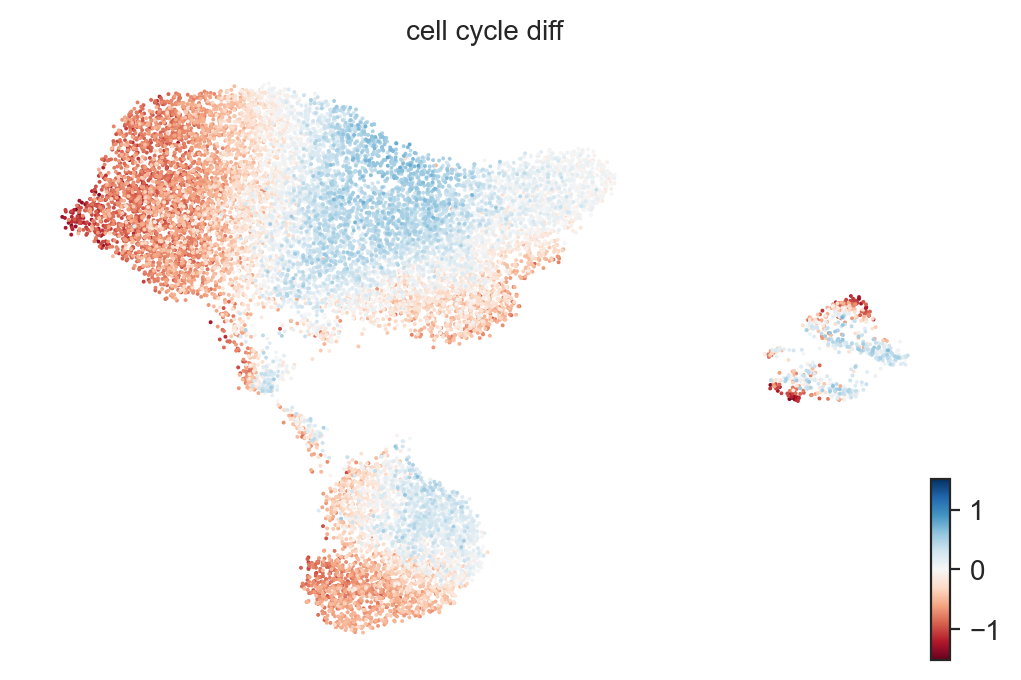

In [9]:
from matplotlib.colors import CenteredNorm 
scv.pl.umap(adata, color=['cell_cycle_diff'], cmap = 'RdBu', norm=CenteredNorm(0), save = 'cc_diff.png', dpi = 200)

In [50]:
adata_cc = sc.pp.regress_out(adata, keys='cell_cycle_diff', copy=True)
sc.pp.scale(adata_cc)

In [51]:
sc.tl.pca(adata_cc, n_comps=50, use_highly_variable=False)
scv.pp.neighbors(adata_cc, random_state=0)
scv.tl.umap(adata_cc, random_state=0)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [2]:
# adata_cc = sc.read_h5ad('../../out/RPM-time-series/adata_cc_01.h5ad')

saving figure to file ./figures/scvelo_cc_diff_corrected.png


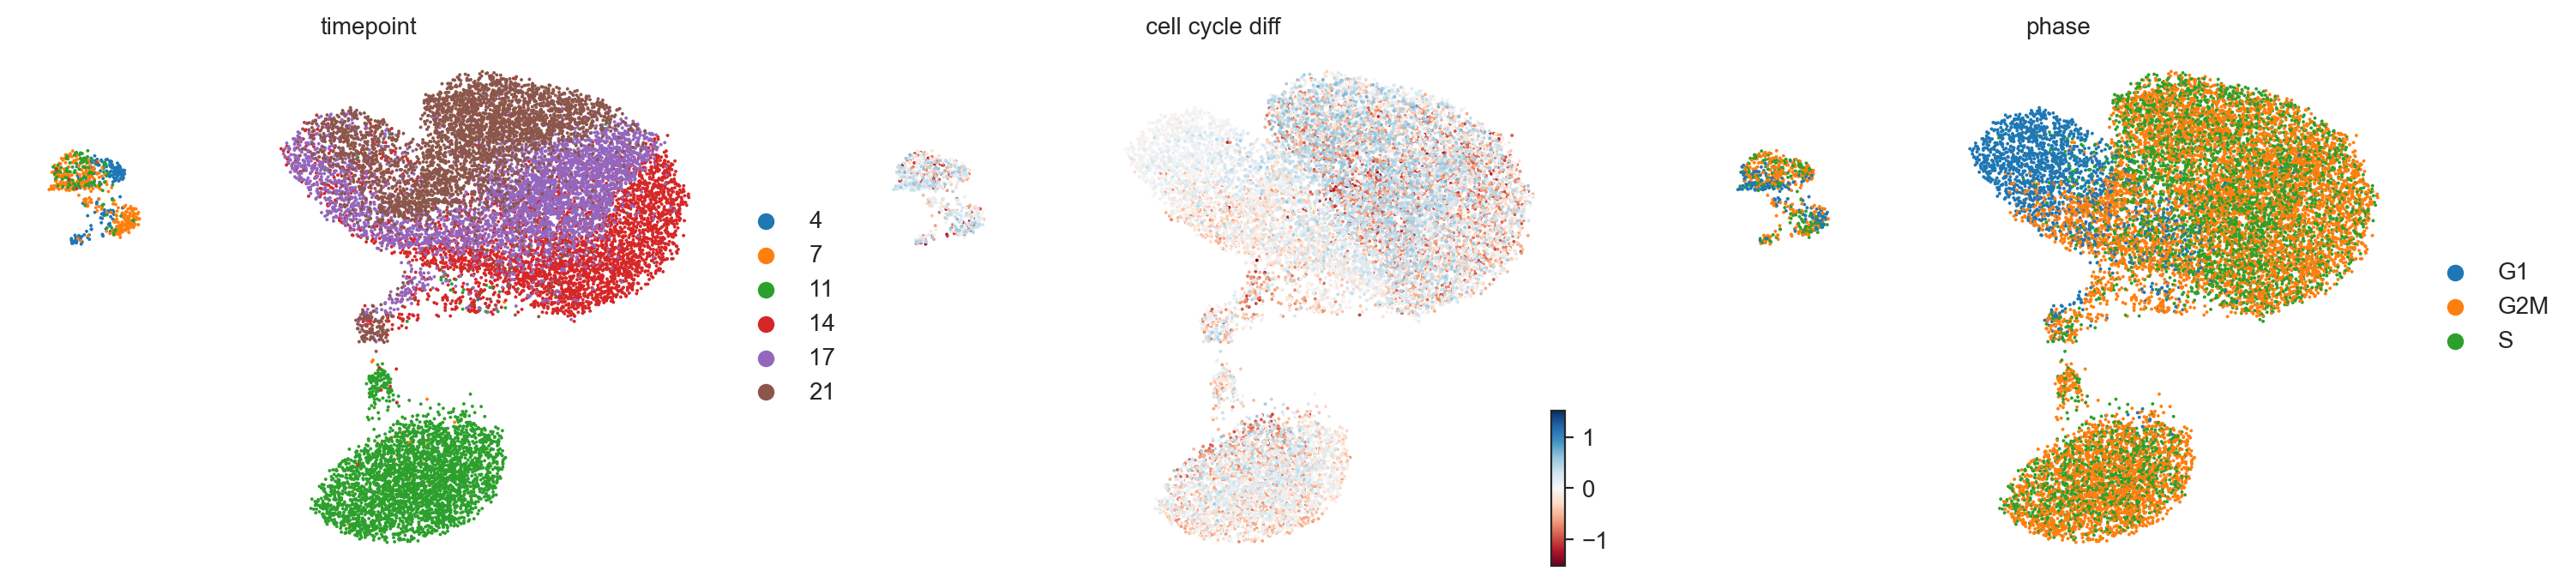

In [5]:
from matplotlib.colors import CenteredNorm 

scv.pl.umap(adata_cc, color=['timepoint','cell_cycle_diff','phase'], legend_loc = 'on right',cmap = 'RdBu', norm=CenteredNorm(0),save = 'cc_diff_corrected.png', dpi = 200)

In [62]:
adata.obs = pd.merge(tmp[['Diffusion Pseudotime','Monocle Pseudotime']], adata.obs, left_index=True, right_index=True)

In [63]:
adata_cc.obs = pd.merge(tmp[['Diffusion Pseudotime','Monocle Pseudotime']], adata_cc.obs, left_index=True, right_index=True)

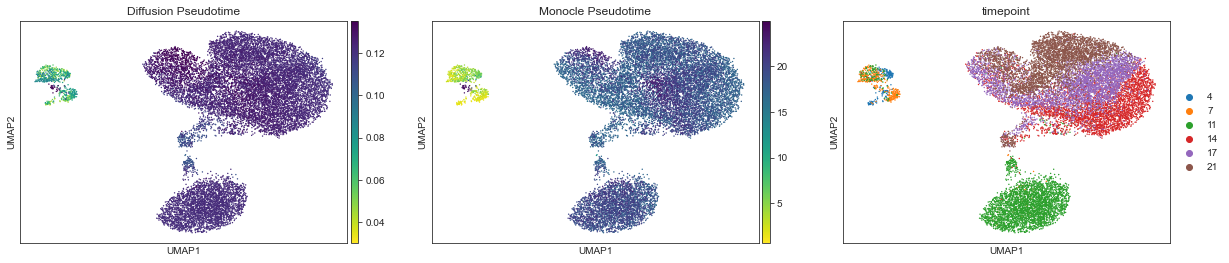

In [70]:
sc.pl.umap(adata_cc, color=['Diffusion Pseudotime','Monocle Pseudotime', 'timepoint'], cmap = 'viridis_r')

## Saving

Because we filtered out the dropkick cells after filtering cells and genes with scanpy, we need to doublecheck that all of the genes are actually expressed in the dataset, so we'll do a small filter to get rid of any genes we missed.

In [71]:
sc.pp.filter_genes(adata, min_cells=3)

In [72]:
adata.write_h5ad('../../out/RPM-time-series/adata_01.h5ad')

In [73]:
sc.pp.filter_genes(adata_cc, min_cells=3)
adata_cc.write_h5ad('../../out/RPM-time-series/adata_cc_01.h5ad')

In [74]:
adata

AnnData object with n_obs × n_vars = 15138 × 18355
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'timepoint_colors', 'predicted_doublets_colors', 'clusters_gradients_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [75]:
adata_cc

AnnData object with n_obs × n_vars = 15138 × 19455
    obs: 'Diffusion Pseudotime', 'Monocle Pseudotime', 'Clusters', '_X', '_Y', 'batch', 'doublet_scores', 'predicted_doublets', 'timepoint', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'barcode', 'ireland_barcode', 'M', 'E', 'clusters_gradients', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'mean', 'std', 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'timepoint_colors', 'predicted_doublets_colors', 'clusters_gradients_colors', 'phase_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'